In [1]:
import numpy as np
import batman, os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.time import Time
from astropy import units
from tqdm import tqdm_notebook

import starry
starry.config.lazy = False
starry.config.quiet = True



COLOR='white'

plt.rcParams['font.size'] = 20
plt.rcParams['text.color'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
#plt.rcParams['axes.spines.top'] = False
#plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['axes.edgecolor'] = COLOR
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['legend.facecolor'] = 'none'


parula_colors = np.load('/Users/arcticfox/parula_colors.npy')

plt_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/figures'

In [2]:
direct = '/Users/arcticfox/Downloads/gemini_data'
files = np.sort([os.path.join(direct, i) for i in os.listdir(direct) 
                 if i.endswith('.fits')])

header_times = []
for i in np.arange(len(files)):
    hdu = fits.open(files[i])
    try:
        header_times.append(hdu[0].header['MJDate'])
    except:
        pass
    hdu.close()
    
OBS_TIME = Time(header_times, format='mjd')#.jd

In [3]:
OBS_TIME = OBS_TIME.jd

In [4]:
def spot_lightcurve(t):
    map = starry.Map(ydeg=5)

    P = 2.865
    alpha = 0.04

    map = starry.Map(ydeg=5, 
                     udeg=2,
                     inc=80,
                     amp=1.0,
                     r=1.305,
                     m=1.10,
                     prot=P,
                     alpha=alpha)

    map[1:] = [0, 0]#0.591, 0.098]

    a = 0.045
    sig1, sig2 = 0.2, 0.15
    amps = [a, -a, a+0.01, -a-0.01]#, a, -a]
    lat = [78, 78, 0, 0]#, -75, -75]
    lon = [-85, -85, -100, -100]#, -75, -75]
    sig = [0.18, sig2, 0.178, 0.155]#, 0.17, 0.155]

    for i in range(len(amps)):
        map.add_spot(amp=amps[i], sigma=sig[i], lat=lat[i], lon=lon[i])
        omega_eq = 360.0 / P
        omega = omega_eq * (1 - alpha * np.sin(30 * np.pi / 180.0) ** 2)

        if i > 0:
            flux_true += map.flux(theta=omega*t)
        else:
            flux_true = map.flux(theta=omega * t)

    return flux_true/np.nanmedian(flux_true), map

In [5]:
def batman_model(time, vals):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = vals[0]                       #time of inferior conjunction
    params.per = vals[1]                       #orbital period
    params.rp = vals[2]                       #planet radius (in units of stellar radii)
    params.a = vals[3]                        #semi-major axis (in units of stellar radii)
    params.inc = 89.                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [vals[4], vals[5]]     #limb darkening coefficients [u1, u2, u3, u4]

    m = batman.TransitModel(params, time)    #initializes model
    return m.light_curve(params)

In [6]:
c_old, c_new = 2454833+2231.2797, 2458846.097156
d_old, d_new = 2454833+2239.3913, 2458845.803649

planetd_params_old = [d_old, 12.4032, 0.0436, 17.31, 0.591, 0.098]
planetc_params_old = [c_old, 8.24958, 0.0381, 13.19, 0.591, 0.098]

planetd_params_new = [d_new, 12.4032, 0.0436, 17.31, 0.591, 0.098]
planetc_params_new = [c_new, 8.24958, 0.0381, 13.19, 0.591, 0.098]

time = np.linspace(OBS_TIME[0]-0.75, OBS_TIME[-1]+0.75, 1000)

In [7]:
c_lightcurve_old = batman_model(time, planetc_params_old)
c_lightcurve_new = batman_model(time, planetc_params_new)

d_lightcurve_old = batman_model(time, planetd_params_old)
d_lightcurve_new = batman_model(time, planetd_params_new)

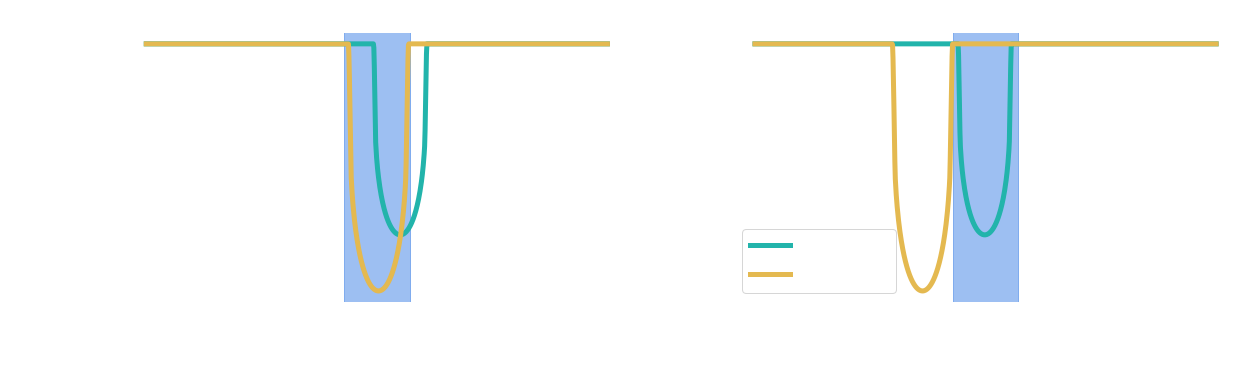

In [617]:
batman_time_hours = ((time-time[0])*units.day)
obs_time_hours = ((OBS_TIME-time[0])*units.day).value

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,5), sharex=True,
                               sharey=True)

ax1.plot(batman_time_hours, c_lightcurve_old, lw=5, label='Planet c', c=parula_colors[120])
ax1.plot(batman_time_hours, d_lightcurve_old, lw=5, label='Planet d', c=parula_colors[200])

#ax1.legend(bbox_to_anchor=(0., 1.02, 1., .12), loc='lower left',
#           borderaxespad=0., ncol=2, fontsize=18, mode='expand')

ax2.plot(batman_time_hours, c_lightcurve_new, lw=5,  c=parula_colors[120], label='Planet c')
ax2.plot(batman_time_hours, d_lightcurve_new, lw=5,  c=parula_colors[200], label='Planet d')


ax1.axvspan(obs_time_hours[0], obs_time_hours[-1], color=parula_colors[30], alpha=0.4)
ax2.axvspan(obs_time_hours[0], obs_time_hours[-1], color=parula_colors[30], alpha=0.4)

ax2.set_xlabel('Time [Days]', fontsize=26)
ax1.set_xlabel('Time [Days]', fontsize=26)
ax1.set_ylabel('batman Transit Model', fontsize=26)

ax1.set_title('K2 Ephemerides')
ax2.set_title('Updated Spitzer Ephemerides')
ax2.legend()
#ax2.set_xlim(OBS_TIME[0]-0.75-2400000, OBS_TIME[-1]+0.75-2400000)

#plt.savefig('/Users/arcticfox/Desktop/transits.png', dpi=250,
#            rasterize=True, bbox_inches='tight', transparent=True)

In [8]:
prot = 2.865 * units.day
obs_len = (OBS_TIME[-1]-OBS_TIME[0])*units.day

delta_theta = ((np.diff(OBS_TIME)*units.day*360)/prot).value
starting_theta = 100
avg_delta_theta = np.nanmedian(delta_theta)
avg_delta_theta

0.6282722372659213

In [9]:
from scipy.interpolate import RegularGridInterpolator

def regrid(data, out_x, out_y):
    m = max(data.shape[0], data.shape[1])
    y = np.linspace(0, 1.0/m, data.shape[0])
    x = np.linspace(0, 1.0/m, data.shape[1])
    interpolating_function = RegularGridInterpolator((y, x), data)

    yv, xv = np.meshgrid(np.linspace(0, 1.0/m, out_y), np.linspace(0, 1.0/m, out_x))

    return interpolating_function((xv, yv))

In [10]:
30*avg_delta_theta

18.84816711797764

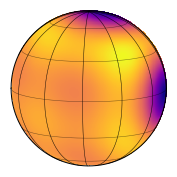

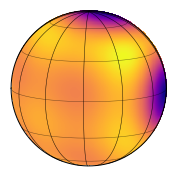

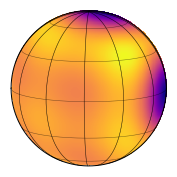

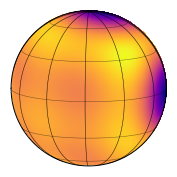

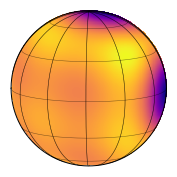

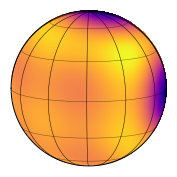

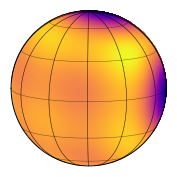

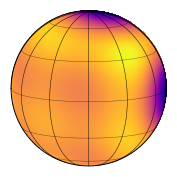

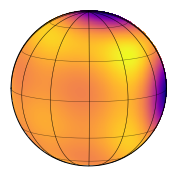

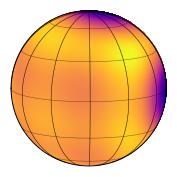

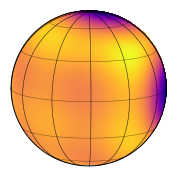

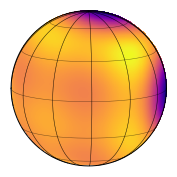

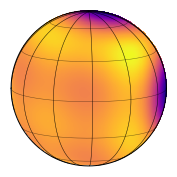

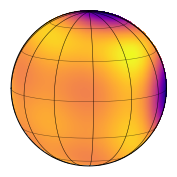

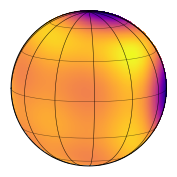

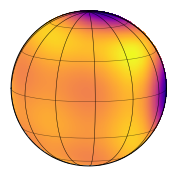

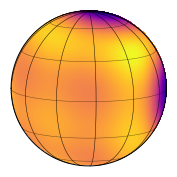

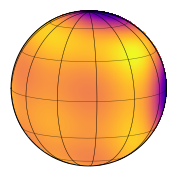

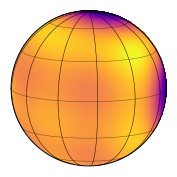

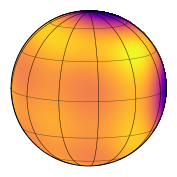

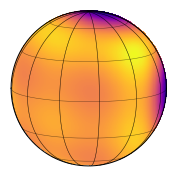

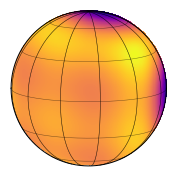

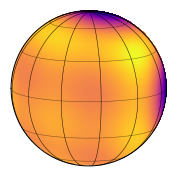

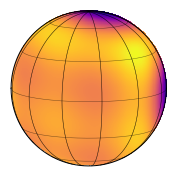

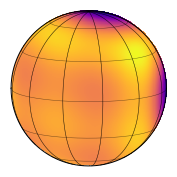

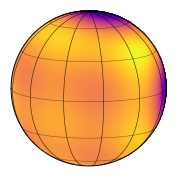

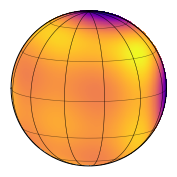

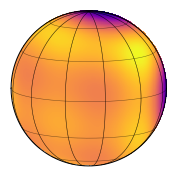

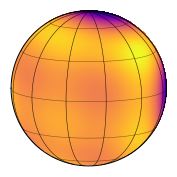

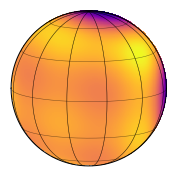

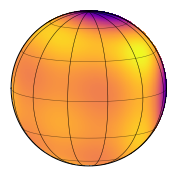

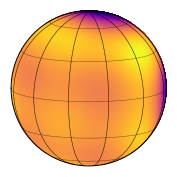

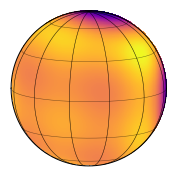

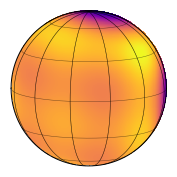

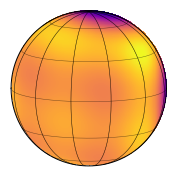

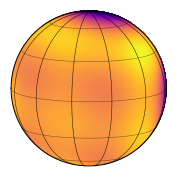

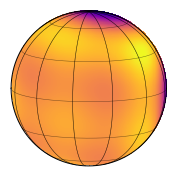

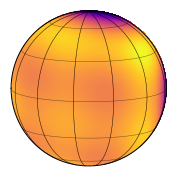

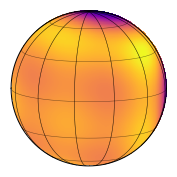

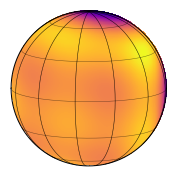

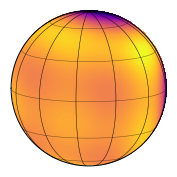

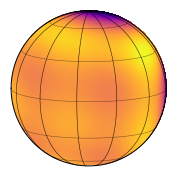

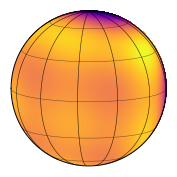

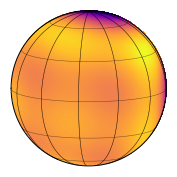

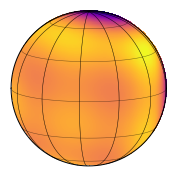

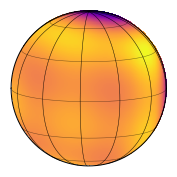

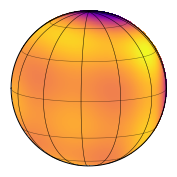

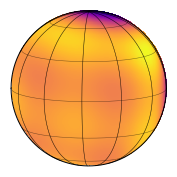

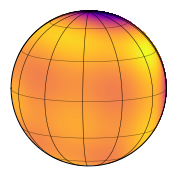

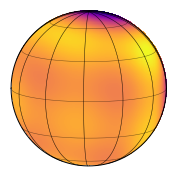

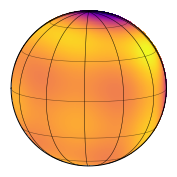

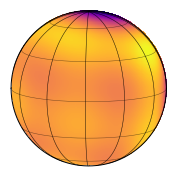

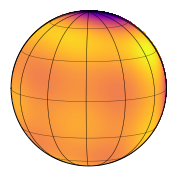

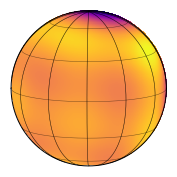

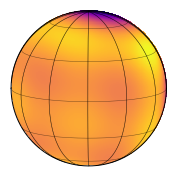

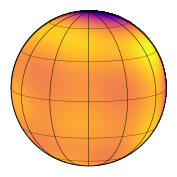

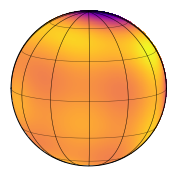

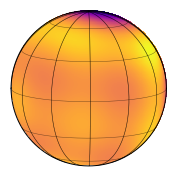

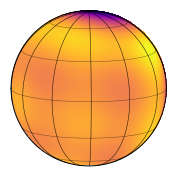

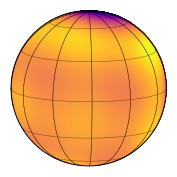

In [11]:
spots, starry_map = spot_lightcurve(time)

for i in tqdm_notebook(range(120,180)):

    img, _, _ = starry_map.show(theta=starting_theta+(i*avg_delta_theta), 
                                projection='ortho')
    plt.close()

    ds = np.full((img.shape[0], img.shape[1]), np.nan)

    x_surf, y_surf = np.where(img >= 0.31)
    ds[x_surf, y_surf] = 1

    x_spot, y_spot = np.where(img <= 0.3)
    ds[x_spot, y_spot] = 0

    x_fac, y_fac = np.where( (img <= 0.31) & (img>=0.3) )
    ds[x_fac, y_fac] = 2
    
    rsize = 2500
    regridded_surfaces = np.zeros((rsize, rsize))

    rg = regrid(ds, rsize, rsize)
    rg[(rg<2) & (rg>=0.5)] = 1
    rg[(rg>=2)] = 2
    rg[rg<0.5] = 0
    
    np.save(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/spot_surfaces/',
                         'spot_map{0:03d}.npy'.format(starting_theta+i)), rg)

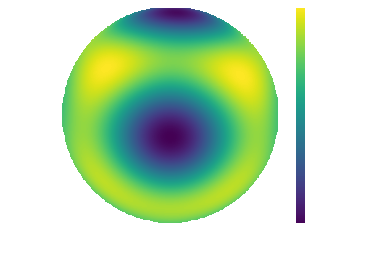

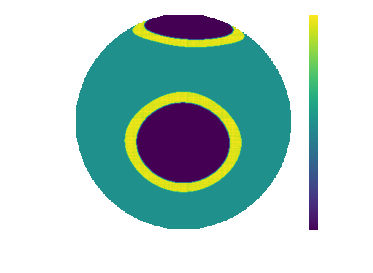

In [895]:
# turn off limbdarkening here and apply later
plt.imshow(img, origin='lower')#, vmin=0, vmax=2)
plt.colorbar()
plt.show()
plt.imshow(rg, origin='lower', vmin=0, vmax=2)
plt.colorbar()

In [623]:
len(np.where(rg==2)[0])/(len(np.where(rg==0)[0]) + len(np.where(rg==2)[0]))

0.4781998731450351

([<matplotlib.axis.YTick at 0x61ab4ea20>,
 <a list of 3 Text major ticklabel objects>)

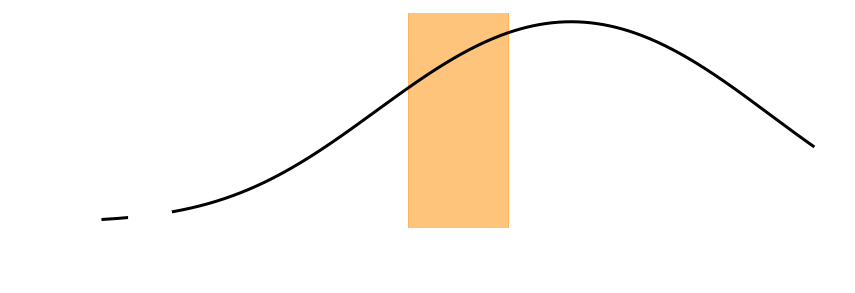

In [905]:
plt.figure(figsize=(14,4))

plt.plot(time, spots, 'k', lw=3)
args = np.arange(40,40+53,1,dtype=int)
plt.plot(time[args], spots[args], 'wo', lw=3)

plt.axvspan(OBS_TIME[0], OBS_TIME[-1], color='darkorange', alpha=0.3)
plt.axvspan(OBS_TIME[0], OBS_TIME[-1], color='darkorange', alpha=0.3)
plt.yticks([0.98,1.0,1.02])
#plt.plot(time, spots+c_lightcurve_old+d_lightcurve_old-2)

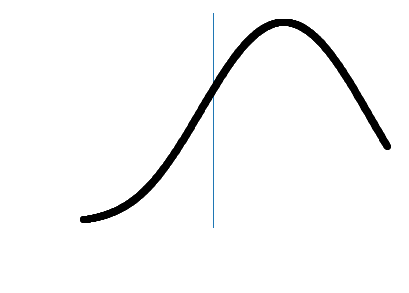

In [917]:
spots, _ = spot_lightcurve(time)
plt.plot(time, spots,'ko')
plt.axvspan(OBS_TIME[0], OBS_TIME[1])

In [918]:
savedir = '/Users/arcticfox/Documents/atmospheres/v1298tau/spot_surfaces/best_fit'
np.save(os.path.join(savedir, 'simulated_lc.npy'),
        [time, spots, OBS_TIME])

//anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
